In [1]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
# read input files

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# do necessary preprocessing

X_train = train.drop('label', axis=1)
y_train = train['label']

X_train = X_train / 255.0
X_test = test / 255.0

X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train, num_classes=10)

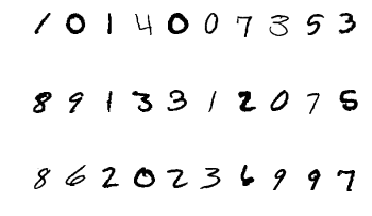

In [4]:
# show some datasets

for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)
    plt.axis('off')
plt.show()

In [5]:
# initialize data augmentation

datagen = ImageDataGenerator(rotation_range = 10,
                             zoom_range = 0.1,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1)

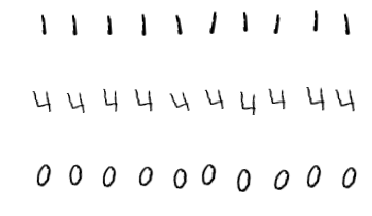

In [6]:
# show some data augmentation

X_train3 = X_train[2,].reshape(1, 28, 28, 1)
y_train3 = y_train[2,].reshape(1, 10)
for i in range(30):
    plt.subplot(3, 10, i+1)
    X_train2, y_train2 = datagen.flow(X_train3, y_train3).next()
    plt.imshow(X_train2[0].reshape(28,28), cmap=plt.cm.binary)
    plt.axis('off')
    if i == 9:
        X_train3 = X_train[3,].reshape(1, 28, 28, 1)
        y_train3 = y_train[3,].reshape(1, 10)
    if i == 19:
        X_train3 = X_train[5,].reshape(1, 28, 28, 1)
        y_train3 = y_train[5,].reshape(1, 10)
plt.show()

In [7]:
# build 15 convolutional neural networks

nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
# decrease learning rate at each epoch

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [ ]:
# train models with 45 epochs

history = [0] * nets
epochs = 45
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2, Y_train2, batch_size=64),
                                        epochs = epochs,
                                        steps_per_epoch = X_train2.shape[0]//64,
                                        validation_data = (X_val2, Y_val2),
                                        callbacks = [annealer],
                                        verbose = 0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1, epochs, max(history[j].history['acc']), max(history[j].history['val_acc'])))

Instructions for updating:
Use tf.cast instead.


In [ ]:
# ensemble predictions and submit

results = np.zeros((X_test.shape[0], 10)) 
for j in range(nets):
    results = results + model[j].predict(X_test)

results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")
submission = pd.concat([pd.Series(range(1, 28001), name = "ImageId"), results], axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv", index=False)

In [ ]:
# preview predictions

plt.figure(figsize=(15, 6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(X_test[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.title("predict=%d" % results[i], y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()